# Mapping Wetlands in Kuwait using GEOBIA

## Abdullatif Alyaqout

# Introduction

Wetlands, or mudflats, are low-lands where the soil salinity increases due to water evaporation. They usually exist proximate to water bodies. In Kuwait, wetlands are located close to the coastal areas, and mostley found in the southern part of the country. 

Mapping the spatial distribution of wetlands and creating a historical records to understand their dynamics is important, since several developing projects are undergoing in Kuwait.

In this project, GEOBIA is used to detect the wetlands in Kuwait.

# Methodology

## Satellite Image

Sentinel-2 image is used for the segmentation and classification.

- 10 bands were selected for the segmentation and classification

- The bands are 20m resolution

    - The VIS/NIR bands are originally 10m, but they were resampled

- Extra layer (Normalized Multi-band Drought Index (NMDI)) was calculated to enhance wetlands extraction (maybe!).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


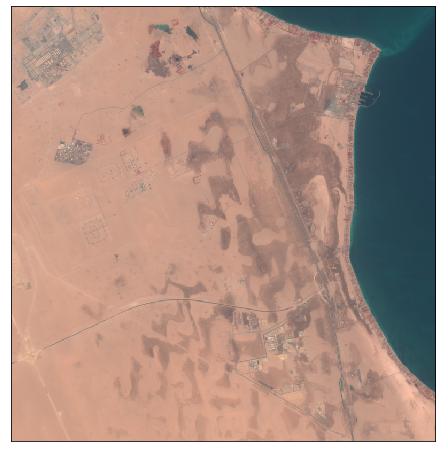

In [242]:
with rasterio.open("./images/KW_clip.tif") as src:
    
    image = src.read([7,2,1])

    fig, ax = pyplot.subplots(1, figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])



    show(image/4500)
   

## Loading the required libraries for segmentation step

In [243]:
from os import environ
import time
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.plot import show
from rasterio import features
from affine import Affine
import geopandas as gpd
from geopandas import GeoDataFrame
from skimage.segmentation import slic, felzenszwalb, watershed, quickshift
from skimage.future import graph
from skimage.morphology import disk
from skimage.filters.rank import modal
from skimage.measure import regionprops, label
from skimage.filters import sobel
from skimage.color import rgb2gray
from sklearn import svm
from collections import OrderedDict
import matplotlib
from matplotlib import pyplot 
from rasterstats import zonal_stats
import pickle


## 1- Segmentation

Felzenszwalb algorithm was used. It produced the best segments when compared with the other algorithms.

Since shape and texture parameters are not important in the case of wetlands, they were ignored in the segmentation code.

In [ ]:

with rasterio.open("./images/KW_clip.tif") as src:
 
    felz_params = {
        'scale': 0.5,
        'sigma': 0.5,
        'min_size': 100
    }
    
    #No window used
    image = src.read([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    # Segment the image.
    rout = segmentation(model=felzenszwalb, params=felz_params, image=image)
    vout = vectorize(image=rout, transform=src.transform,
                      crs=src.crs.to_proj4())
    vout.to_file("gpkg/wetlands_felz.gpkg", layer="initialSegments", driver="GPKG")
    # Adding Spectral Properties
    vout = add_zonal_properties(image=image, transform=src.transform, 
                                bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], band_names=['blue', 'green', 'red',
                                                                                   'veg1', 'veg2', 'veg3',
                                                                                   'nir', 'veg4', 'swir1',
                                                                                   'swir2'],
                                stats=['mean'], gdf=vout)
    
    #Adding the NMDI index
    nmdi = (image[3] - (image[8] - image[9])) / (image[3] + (image[8] - image[9]))
    nmdi = nmdi[np.newaxis, :, :]    
    vout = add_zonal_properties(image=nmdi, transform=src.transform, 
                                bands=[1], band_names=['nmdi'],
                                stats=['mean'],
                                gdf=vout)
    vout.to_file("gpkg/wetlands_felz.gpkg", layer="ready2classify1", driver="GPKG")
    print("All done!!")

### Segmentation results

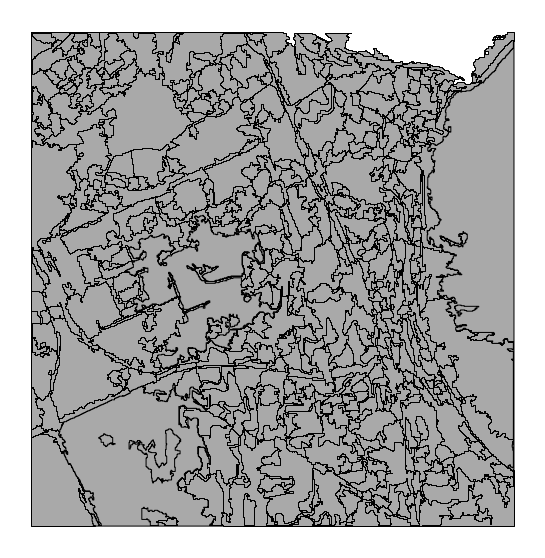

In [212]:
#Visualizing the Segments
gdf = gpd.read_file("gpkg/wetlands_felz.gpkg", layer='ready2classify1')
ax = gdf.plot(figsize = (10,10), color='darkgrey', linewidth=1, edgecolor='k')
ax.set_axis_off()

# 2- Attribution

## Classification scheme

|**Class id**|**Class Description**|
|--------|:---------------------:|
|1       | Wetland         |
|2      | Soil            |
|3       | Water           |
|4       | Built-up        |
|5       | Mixed           |

# 3- Classification

## Loading the required libraries for the classification step

In [ ]:
from scipy.stats import expon
    from sklearn import svm
   from sklearn.model_selection import RandomizedSearchCV
import pickle
import numpy as np
import geopandas as gpd
# from geopandas import GeoDataFrame
import matplotlib
from matplotlib import pyplot

In [ ]:
for_training = gpd.read_file("rag_and_zonal_statistics/gpkg/wetlands_felz.gpkg", layer="ready2classify1")

big_train = for_training[~for_training["class_id"].isnull()]

labels = big_train['class_id']

classes = big_train[["blue_mean", "green_mean", "red_mean",
                     "veg1_mean","veg2_mean", "veg3_mean", "nir_mean", "veg4_mean", "swir1_mean","swir2_mean",
                     "nmdi_mean"
                     ]]

model = train(classes, labels)

to_predict = for_training[["blue_mean", "green_mean", "red_mean",
                     "veg1_mean","veg2_mean", "veg3_mean", "nir_mean", "veg4_mean", "swir1_mean",
                           "swir2_mean","nmdi_mean"
                     ]]

output = predict(model, to_predict.values)

for_training['classified1'] = output

for_training.to_file("rag_and_zonal_statistics/gpkg/wetlands_felz.gpkg", layer="felz_predictions1", driver="GPKG")

# Classification results

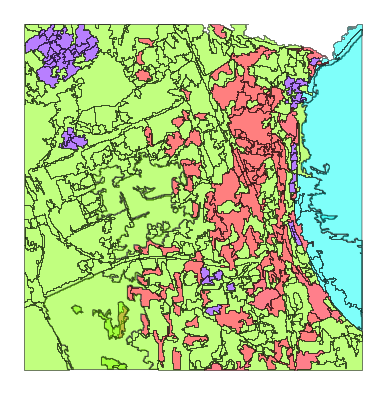

In [251]:
## Classification outputs:
gdf = gpd.read_file("gpkg/wetlands_felz.gpkg", layer='felz_predictions1')
ax = gdf.plot(figsize = (7,7),  linewidth=1, edgecolor='k',
             column = 'classified1', categorical = "true", cmap = 'hsv', alpha = 0.5)
ax.set_axis_off()

# Final wetlands map

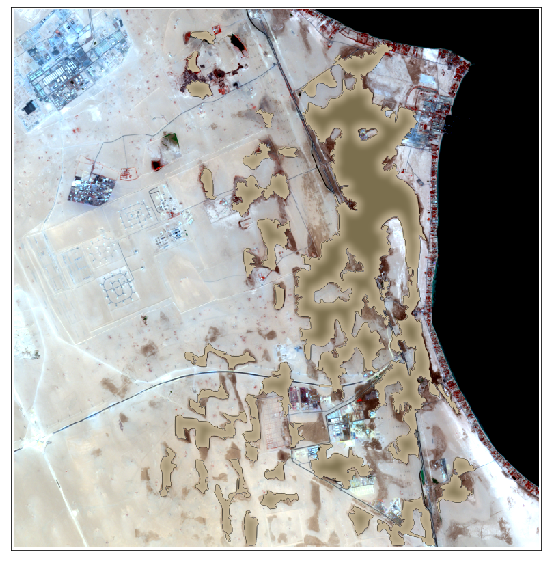

In [249]:
# Wetlands map results
src = rasterio.open("gpkg/wetlands_final.png")
image = src.read()
fig, ax = pyplot.subplots(1, figsize=(10, 10))
ax.set_xticks([])
ax.set_yticks([])
show(image)


# Findings

Mapping wetlands **was not an easy task!**

- several wetlands were segmented with other land features (mixed)
- a lot of iterations in the classification step to preduce better classified segments
    - The training samples were increased during each iteration
- Using a higher resolution image should enhance the segmentation results.

# **Thank You!**